In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
import random
import tensorflow as tf
import re
import os

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
#temp,dew,humidity,cloud_cover,solar_radiation,solar_energy, uv_radiation
# Define initial min and max values
min_val = [1000, 1000, 1000, 1000, 1000, 1000, 1000]
max_val = [-1000, -1000, -1000, -1000, -1000, -1000, -1000]

In [ ]:
def adjust_dataframe_length(df, target_length):
    # Check if df.shape[0] is less than the target length
    if df.shape[0] < target_length:
        df = pd.concat([df, df.tail(target_length - df.shape[0])])

    # Check if df.shape[0] is greater than the target length
    if df.shape[0] > target_length:
        # Create a list of rows where the 4th column (precip) value is 0
        zero_precip_rows = []
        for i in range(len(df)):
            # if df.iloc[i, 3] == 0:
            zero_precip_rows.append(i)

        # Randomly select rows from the list of zero_precip_rows
        rows_to_remove = random.sample(zero_precip_rows, df.shape[0] - target_length)

        # Remove the selected rows from the DataFrame
        df = df.drop(rows_to_remove)
    return df

# Normalize the data using Min-Max scaling
def min_max_scaling(df, min_val, max_val):
    for i, col in enumerate(df.columns):
        df[col] = (df[col] - min_val[i]) / (max_val[i] - min_val[i])
    return df

def append_rows_to_single_row(df):
    # Normalize each column separately
    # Normalize the data using Min-Max scaling
    df_normalized = min_max_scaling(df, min_val, max_val)

    # Create an empty dictionary to store the data
    data_dict = {}

    # Number of days
    num_days = len(df_normalized)

    # Iterate over each row
    for i in range(num_days):
        # Get the data from the current row
        row_data = df_normalized.iloc[i].values

        # Append the data to the dictionary with modified column names
        for j, value in enumerate(row_data):
            column_name = f"{df_normalized.columns[j]}_day_{i+1}"
            data_dict[column_name] = value

    # Convert the dictionary to a DataFrame
    single_row_df = pd.DataFrame([data_dict])

    return single_row_df

def calculate_min_max(df):
    global min_val, max_val
    for i, col in enumerate(df.columns):
        min_val[i] = min(df[col].min(), min_val[i])
        max_val[i] = max(df[col].max(), max_val[i])


def load_and_adjust_data(urls, target_length):

    dfs = []

    for url in urls:
        # Read Excel file into DataFrame
        df = pd.read_excel(url)
        # Fill NaN values with column means
        df= df.drop(columns=['precip'])
        df = df.fillna(df.mean())
        if df.isna().any().any():
            print("NaN values encountered in DataFrame from URL:", url)
        #calculating for min max scaling
        calculate_min_max(df)
        # Adjust the length of the DataFrame
        df = adjust_dataframe_length(df, target_length)
        # Append the adjusted DataFrame to the list
        dfs.append(df)
    return dfs

def extract_label_from_url(url):

    filename = url.split('/')[-1]  # Get the filename from the URL
    label = re.split('_\d+', filename)[1]  # Extract the label based on the pattern
    return label[1:]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
mydrive_path = "/content/drive/MyDrive/ACPS_Project/Modified for model"

# List files in MyDrive with full paths
urls = [os.path.join(mydrive_path, file) for file in os.listdir(mydrive_path)]
print(urls)

['/content/drive/MyDrive/ACPS_Project/Modified for model/Junagadh_2013_wheat_10-05_weather.xlsx', '/content/drive/MyDrive/ACPS_Project/Modified for model/Solan_2014_wheat_10-05_weather.xlsx', '/content/drive/MyDrive/ACPS_Project/Modified for model/Nandurbar_2011_wheat_10-05_weather.xlsx', '/content/drive/MyDrive/ACPS_Project/Modified for model/Davangere_2010_rice_01-09_weather.xlsx', '/content/drive/MyDrive/ACPS_Project/Modified for model/Thiruvarur_2014_rice_01-09_weather.xlsx', '/content/drive/MyDrive/ACPS_Project/Modified for model/Nizamabad_2012_wheat_10-05_weather.xlsx', '/content/drive/MyDrive/ACPS_Project/Modified for model/Karnal_2012_rice_01-09_weather.xlsx', '/content/drive/MyDrive/ACPS_Project/Modified for model/Nagaon_2015_rice_01-09_weather.xlsx', '/content/drive/MyDrive/ACPS_Project/Modified for model/Hanumangarh_2014_rice_01-09_weather.xlsx', '/content/drive/MyDrive/ACPS_Project/Modified for model/Chatra_2014_wheat_10-05_weather.xlsx', '/content/drive/MyDrive/ACPS_Projec

In [ ]:
labels = []
for url in urls:
  labels.append(extract_label_from_url(url))
# Load and adjust the data
dfs = load_and_adjust_data(urls, 180)

# Convert each DataFrame to a single row
single_row_dfs = [append_rows_to_single_row(df) for df in dfs]

# Concatenate the single-row DataFrames
df_concatenated = pd.concat(single_row_dfs, axis=0)

In [ ]:
print(min_val)
print(max_val)

[-9.8, -18.2, 5.5, 0.0, 12.4, 1.1, 1]
[41.9, 28.4, 99.8, 100.0, 403.6, 34.9, 10]


In [ ]:
# Check if there are any NaN values in the DataFrame
if df_concatenated.isna().any().any():
    # Print the rows with NaN values
    print("Rows with NaN values:")
    print(df_concatenated[df_concatenated.isna().any(axis=1)])
# Drop rows with NaN values
df_concatenated = df_concatenated.dropna()

# Print the DataFrame after dropping rows
print(df_concatenated)


    temp_day_1  dew_day_1  humidity_day_1  cloudcover_day_1  \
0     0.705996   0.914163        0.869565             0.642   
0     0.694391   0.783262        0.622481             0.311   
0     0.682785   0.854077        0.794274             0.677   
0     0.638298   0.785408        0.749735             0.383   
0     0.680851   0.828326        0.737010             0.498   
..         ...        ...             ...               ...   
0     0.723404   0.879828        0.761400             0.639   
0     0.713733   0.903433        0.829268             0.337   
0     0.775629   0.858369        0.602333             0.738   
0     0.820116   0.884120        0.582185             0.066   
0     0.936170   0.581545        0.134677             0.463   

    solarradiation_day_1  solarenergy_day_1  uvindex_day_1  temp_day_2  \
0               0.619888           0.621302       0.888889    0.725338   
0               0.405419           0.405325       0.555556    0.684720   
0               0.613

In [ ]:
#Split the data into train and test sets
X_train, X_test = train_test_split(df_concatenated.values, test_size=0.2, random_state=42)

# Further split the training data into train and validation sets
X_train, X_val = train_test_split(X_train, test_size=0.1, random_state=42)

# Reshape the data
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

# Define the input layers
input_layer_train = Input(shape=(X_train.shape[1], X_train.shape[2]))
input_layer_test = Input(shape=(X_test.shape[1], X_test.shape[2]))
input_layer_val = Input(shape=(X_val.shape[1], X_val.shape[2]))

conv1 = Conv1D(512,kernel_size=3,activation='relu')(input_layer_train)
conv2 = Conv1D(512,kernel_size=3,activation='relu')(conv1)
conv3 = Conv1D(128,kernel_size=5,activation='relu')(conv2)
conv4 = Conv1D(128,kernel_size=5,activation='relu')(conv3)
flatten = Flatten()(conv4)

# Define the encoding layers
encoding_layer1 = Dense(512, activation='relu')(flatten)
encoding_layer2 = Dense(256, activation='relu')(encoding_layer1)
encoding_layer3 = Dense(128, activation='relu')(encoding_layer2)

# Define the decoding layers
#decoding_layer1 = Dense(128, activation='relu')(encoding_layer3)
decoding_layer2 = Dense(256, activation='relu')(encoding_layer3)
decoding_layer3 = Dense(512, activation='relu')(decoding_layer2)
decoding_layer4 = Dense(X_train.shape[1], activation='relu')(decoding_layer3)

# Define the autoencoder model
autoencoder = Model(inputs=input_layer_train, outputs=decoding_layer4)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mean_absolute_error')

# Train the autoencoder on the training data
history = autoencoder.fit(X_train, X_train, epochs=1024, validation_data=(X_val, X_val))


# Evaluate the autoencoder on the test set
reconstruction_error_test = autoencoder.evaluate(X_test, X_test)
print("Reconstruction error on test set:", reconstruction_error_test)


Epoch 1/1024
10/10 [==============================] - 4s 148ms/step - loss: 0.5546 - val_loss: 0.4580
Epoch 2/1024
10/10 [==============================] - 1s 110ms/step - loss: 0.3951 - val_loss: 0.3325
Epoch 3/1024
10/10 [==============================] - 1s 112ms/step - loss: 0.3388 - val_loss: 0.3222
Epoch 4/1024
10/10 [==============================] - 1s 106ms/step - loss: 0.3232 - val_loss: 0.3136
Epoch 5/1024
10/10 [==============================] - 1s 106ms/step - loss: 0.3182 - val_loss: 0.3127
Epoch 6/1024
10/10 [==============================] - 1s 110ms/step - loss: 0.3172 - val_loss: 0.3099
Epoch 7/1024
10/10 [==============================] - 1s 108ms/step - loss: 0.3169 - val_loss: 0.3114
Epoch 8/1024
10/10 [==============================] - 1s 108ms/step - loss: 0.3166 - val_loss: 0.3100
Epoch 9/1024
10/10 [==============================] - 1s 107ms/step - loss: 0.3157 - val_loss: 0.3110
Epoch 10/1024
10/10 [==============================] - 1s 105ms/step - loss: 0.315

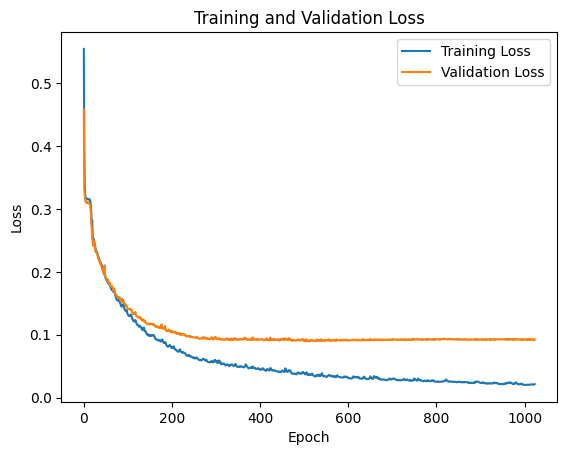

In [ ]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

10/10 [==============================] - 0s 31ms/step - loss: 0.0209
Reconstruction error on training set: 0.02086331881582737
3/3 [==============================] - 0s 29ms/step - loss: 0.0887
Reconstruction error on test set: 0.08866816014051437


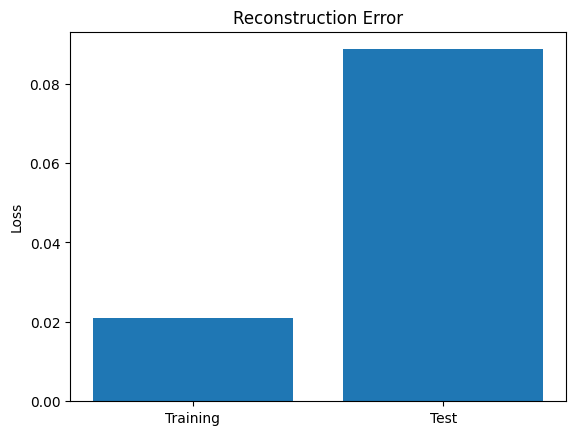

In [ ]:
# Plot the reconstruction error for both training and test sets
reconstruction_error_train = autoencoder.evaluate(X_train, X_train)
print("Reconstruction error on training set:", reconstruction_error_train)
# Evaluate the autoencoder on the test set
reconstruction_error_test = autoencoder.evaluate(X_test, X_test)
print("Reconstruction error on test set:", reconstruction_error_test)
plt.bar(['Training', 'Test'], [reconstruction_error_train, reconstruction_error_test])
plt.title('Reconstruction Error')
plt.ylabel('Loss')
plt.show()

In [ ]:
labels = np.array(labels)
unique_labels = np.unique(labels)
print(unique_labels)

['arhar' 'bajra' 'barley' 'gram' 'jowar' 'maize' 'ragi' 'rice' 'urad'
 'wheat']


In [ ]:
# Map each label to a numerical value
label_mapping = {'jowar': 0, 'rice': 1, 'wheat': 2, 'arhar':3, 'bajra':4, 'barley':5, 'gram':6,'maize':7, 'ragi':8, 'urad':9}

# Convert labels to numerical values
numerical_labels = np.array([label_mapping[label] for label in labels])

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_concatenated.values, numerical_labels, test_size=0.2, random_state=42)

# Further split the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Define the encoder model
encoder_model = Model(inputs=input_layer_train, outputs=encoding_layer3)

# Extract features from the training, validation, and test sets
encoded_train = encoder_model.predict(X_train)
encoded_val = encoder_model.predict(X_val)
encoded_test = encoder_model.predict(X_test)

# Now you can use these encoded representations for further classification tasks
inputs = Input(shape=(encoded_train.shape[1],))
x = Dense(64, activation='relu')(inputs)
xy = Dense(32, activation='relu')(x)
outputs = Dense(10, activation='softmax')(xy)

classifier_model = Model(inputs=inputs, outputs=outputs)

# Compile the classifier model
classifier_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the classifier model
classifier_history = classifier_model.fit(encoded_train, y_train, epochs=300, validation_data=(encoded_val, y_val))

# Evaluate the classifier model on the test set
classifier_loss, classifier_accuracy = classifier_model.evaluate(encoded_test, y_test)
print("Classifier accuracy on test set:", classifier_accuracy)


3/3 [==============================] - 0s 24ms/step
Epoch 1/100
10/10 [==============================] - 1s 29ms/step - loss: 2.1839 - accuracy: 0.2848 - val_loss: 2.0789 - val_accuracy: 0.5143
Epoch 2/100
10/10 [==============================] - 0s 8ms/step - loss: 1.9833 - accuracy: 0.4401 - val_loss: 1.9491 - val_accuracy: 0.4286
Epoch 3/100
10/10 [==============================] - 0s 8ms/step - loss: 1.8223 - accuracy: 0.4013 - val_loss: 1.8359 - val_accuracy: 0.4286
Epoch 4/100
10/10 [==============================] - 0s 10ms/step - loss: 1.6728 - accuracy: 0.4887 - val_loss: 1.7434 - val_accuracy: 0.5429
Epoch 5/100
10/10 [==============================] - 0s 10ms/step - loss: 1.5374 - accuracy: 0.5405 - val_loss: 1.6613 - val_accuracy: 0.5714
Epoch 6/100
10/10 [==============================] - 0s 10ms/step - loss: 1.4118 - accuracy: 0.5534 - val_loss: 1.5921 - val_accuracy: 0.6000
Epoch 7/100
10/10 [==============================] - 0s 9ms/step - loss: 1.2919 - accuracy: 0.6084

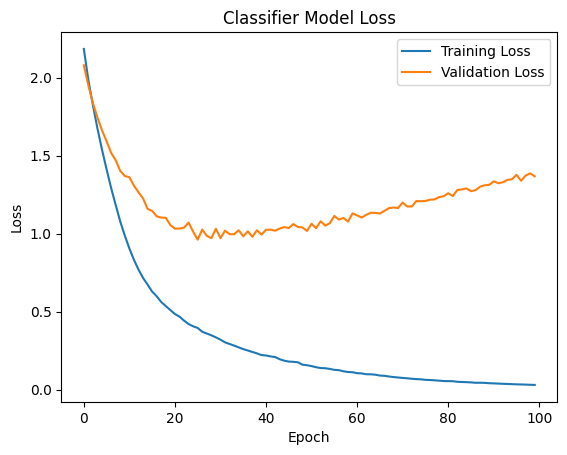

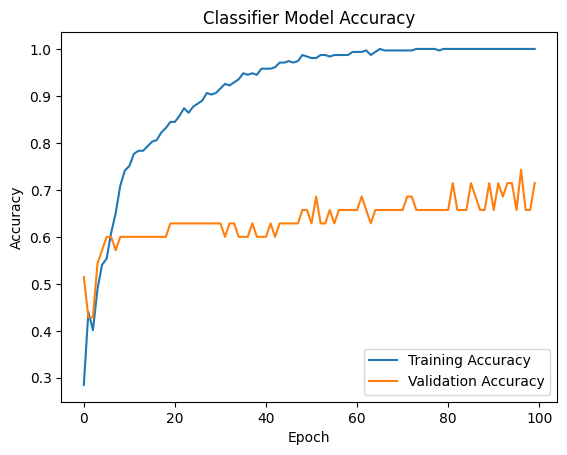

In [ ]:
# Plot training loss
plt.plot(classifier_history.history['loss'], label='Training Loss')
# Plot validation loss
plt.plot(classifier_history.history['val_loss'], label='Validation Loss')
plt.title('Classifier Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training accuracy
plt.plot(classifier_history.history['accuracy'], label='Training Accuracy')
# Plot validation accuracy
plt.plot(classifier_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Classifier Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Make predictions on the test data
predictions = classifier_model.predict(encoded_test)

# Convert predicted probabilities into class labels
predicted_labels = np.argmax(predictions, axis=1)

accuracy = np.mean(predicted_labels == y_test)

print("Accuracy:", accuracy)


3/3 [==============================] - 0s 4ms/step
Accuracy: 0.7441860465116279


In [ ]:
def predict_categories_from_urls(urls, encoder_model, classifier_model):
    # Load and adjust the data
    datas = load_and_adjust_data(urls, 180)

    # Convert each DataFrame to a single row
    single_row_datas = [append_rows_to_single_row(data) for data in datas]

    # Concatenate the single-row DataFrames
    datas_concatenated = pd.concat(single_row_datas, axis=0)

    # Use the trained encoder model to extract features from the reconstructed data
    encoded_reconstructed_data = encoder_model.predict(datas_concatenated.values.reshape(datas_concatenated.shape[0], datas_concatenated.shape[1], 1))

    # Make predictions on the reconstructed data using the classifier model
    predictions = classifier_model.predict(encoded_reconstructed_data)

    # Convert predicted probabilities into class labels
    predicted_labels = np.argmax(predictions, axis=1)

    # Map the class labels to their corresponding categories
    category_mapping = {0: 'jowar', 1: 'rice', 2: 'wheat',3:'arhar',4: 'bajra',5: 'barley',6: 'gram',7: 'maize',8: 'ragi',9:'urad'}
    predicted_categories = [category_mapping[label] for label in predicted_labels]

    return predicted_categories


In [ ]:
test_urls = ['/content/drive/MyDrive/ACPS_Project/Modified for model/Adilabad_2015_wheat_10-05_weather.xlsx']
predicted_categories = predict_categories_from_urls(test_urls, encoder_model, classifier_model)
print("Predicted categories:", predicted_categories)


1/1 [==============================] - 0s 18ms/step
Predicted categories: ['wheat']


In [ ]:
encoder_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1260, 1)]         0         
                                                                 
 conv1d_8 (Conv1D)           (None, 1258, 512)         2048      
                                                                 
 conv1d_9 (Conv1D)           (None, 1256, 512)         786944    
                                                                 
 conv1d_10 (Conv1D)          (None, 1252, 128)         327808    
                                                                 
 conv1d_11 (Conv1D)          (None, 1248, 128)         82048     
                                                                 
 flatten_2 (Flatten)         (None, 159744)            0         
                                                                 
 dense_18 (Dense)            (None, 512)               8178

In [ ]:
classifier_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 128)]             0         
                                                                 
 dense_24 (Dense)            (None, 64)                8256      
                                                                 
 dense_25 (Dense)            (None, 32)                2080      
                                                                 
 dense_26 (Dense)            (None, 10)                330       
                                                                 
Total params: 10666 (41.66 KB)
Trainable params: 10666 (41.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
autoencoder.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1260, 1)]         0         
                                                                 
 conv1d_8 (Conv1D)           (None, 1258, 512)         2048      
                                                                 
 conv1d_9 (Conv1D)           (None, 1256, 512)         786944    
                                                                 
 conv1d_10 (Conv1D)          (None, 1252, 128)         327808    
                                                                 
 conv1d_11 (Conv1D)          (None, 1248, 128)         82048     
                                                                 
 flatten_2 (Flatten)         (None, 159744)            0         
                                                                 
 dense_18 (Dense)            (None, 512)               8178